In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor
 

%matplotlib inline

In [2]:
df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv')

# сразу создам
#  копируют ID из теста в df preds_final
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

# заменили штатный Id на ID дынный сетом данных и индексировали по этому столбу
X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


0

In [1]:
# X

In [3]:
# X.set_index('Id', inplace=True)

In [4]:
# X

In [5]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [6]:
# X[X['HouseYear'] > 2020].head()

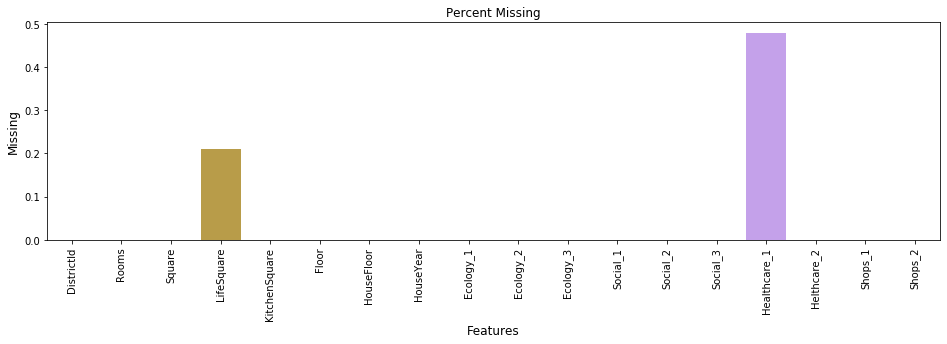

In [7]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

In [8]:
# X.median()

In [11]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        #  НЕ ПОНЯЛ ЗАЧЕМ?
        
    def fit(self, X):
        self.medians = X.median()
        #  медианы каждого столбца
        
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] < 1, 'Rooms'] = 1
#         X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!



        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 500),'KitchenSquare_outlier'] = 1
#         X.loc[X['KitchenSquare'] > 500, 'KitchenSquare','KitchenSquare_outlier'] = 1
#         X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        X['KitchenSquare_outlier2'] = 0
        X.loc[(X['LifeSquare']//X['KitchenSquare'])<1,'KitchenSquare_outlier2'] = 1
        X.loc[(X['LifeSquare']//X['KitchenSquare'])<1,'KitchenSquare'] = self.medians['KitchenSquare']
        
        X['KitchenSquare_outlier3'] = 0
        X.loc[(X['KitchenSquare'] - X['KitchenSquare'].mean()).abs() > 3 * X['KitchenSquare'].std(), 'KitchenSquare_outlier3'] = 1
 
        X['KitchenSquare_outlier4'] = 0
        X.loc[X['Square'] < X['KitchenSquare'], 'KitchenSquare_outlier4'] = 1
        X.loc[X['Square'] < X['KitchenSquare'], 'KitchenSquare'] = self.medians['KitchenSquare']
    
    
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1 #self.medians['HouseFloor']
        
        X['HouseFloor_outlier2'] = 0
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier2'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        
        
        
#         Square
        X['Square_outlier'] = 0
        X.loc[X['Square'] < X['LifeSquare'], 'Square_outlier'] = 1
        X.loc[X['Square'] < X['LifeSquare'], 'Square'] = X['LifeSquare'] + X['KitchenSquare']
        
        X['Square_outlier2'] = 0
        X.loc[X['Square'] > 1000, 'Square_outlier2'] = 1
        X.loc[X['Square'] > 1000, 'Square'] = self.medians['Square']
        
        X['Square_outlier3'] = 0
        X.loc[(X['Square'] - X['Square'].mean()).abs() > 3 * X['Square'].std(), 'Square_outlier3'] = 1
    
    

#   LifeSquare  
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'] - X['LifeSquare'].mean()).abs() > 3 * X['LifeSquare'].std(), 'LifeSquare_outlier'] = 1
    
# Доля жилой площади в общей площади
        X['LifeSquare_share'] = X['LifeSquare'] / X['Square'] * 100

# Доля площади кухни в общей площади
        X['KitchenSquare_share'] = X['KitchenSquare'] / X['Square']* 100    
    
# Доля этажа в общей высоте дома
        X['Floor_in the house'] = X['Floor'] / X['HouseFloor']* 100
    
# Площадь комнаты
        X['Room_square'] = X['LifeSquare'] / X['Rooms']
    
        
        
    
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
#         0 или 1 в столбе, где была инфа и где отсутствовала
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
#         только в случае если все 3 данные присутствуют будет работать формула ниже
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X

In [12]:
# создаем обект imputer класса FeatureImputer
imputer = FeatureImputer()

# запускаем функцию класса fit для расчета медиан в каждом столбе
imputer.fit(X) # расчет медиан

# запускаем функцию класса transform для внесения замен в таблице трейн
X = imputer.transform(X)

# запускаем функцию класса transform для внесения замен в таблице тест
X_final = imputer.transform(X_final)

In [2]:
# X.info()

In [14]:
# district = X['DistrictId'].value_counts()
# district = district[district > 50]
# district =dict(district)
# district

In [15]:
# X['Price'] = y.values
# X

In [16]:
# X['DistrictId_popular'] = X['DistrictId'].copy()
# X

In [17]:
# X.loc[~X['DistrictId_popular'].isin(district.keys())] = np.nan
# X

In [18]:
# district_by_groupby= X.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'})
# district_by_groupby

In [19]:
# DistrictId_counts = dict(district)
# X['DistrictId_count'] = X['DistrictId'].map(DistrictId_counts)
# X

In [20]:
# X['DistrictId'].value_counts().median()

In [27]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.median_rooms_district = None
        self.median_rooms_house_year = None
        self.median_Price_m2 = None
# все новые фичи, которые мы создаем, могут отсутствовать в новом датасете
        
    def fit(self, X, y=None):
        
        self.medians = X.median()
        #  медианы каждого столбца
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
            
# отфильтровали строки только строки с дистриктами, где более 50 наблюдений

        self.DistrictId_counts = dict(district)
# зачем-то создали словарь из район-количество наблюдений
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
     
    
        # Target encoding
        ## District фича- популярный район 
# будем работать на временном датасете
        df = X.copy()
        
        if y is not None:
# если есть цены,то
            df['Price'] = y.values
# на время добавляем столбик с ценой в датасет

            df['DistrictId_popular'] = df['DistrictId'].copy()
# зачем-то копируем столбик Дистрик в столбик ДистриктПопюлар

            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
# если номер дистрикта есть в словаре  самых популярных дистриктов, то заполняем столбец Nan
# Метод ndarray.tolist() преобразует массив NumPy в список Python.
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
# сделали табличку,где отобрали значения дистрикта, комнаты и средней цены, переименовали названия столбцов в табличке            
    
        ## floor, year
        if y is not None:
# если есть цены,то
            df['Price'] = y.values
# на время добавляем столбик с ценой в датасет
            df = self.floor_to_cat(df)
# запускаем функцию, которая вносит правки во временныйдатасет
            df = self.year_to_cat(df)
# запускаем функцию, которая вносит правки во временны датасет
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
# сделали табличку,где отобрали значения категории этажности и категории годов постройки и средней цены,
# переименовали названия столбцов в табличке  
       

    
#     мои фичи
# # среднее количество комнат в районе
        df['DistrictId'] = df['DistrictId'].copy()
        df['median_rooms_district'] = 0
        self.median_rooms_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'median_rooms_district':'median'})
# #     .\                                            rename(columns={'Rooms_med':'median_rooms_district'})

# # среднее количество комнат в зависимости от года постройки
        df['median_rooms_house_year'] = 0
        df['HouseYear'] = df['HouseYear'].copy()
        self.median_rooms_house_year = df.groupby(['HouseYear', 'Rooms'], as_index=False).agg({'median_rooms_house_year':'median'})
# #         .\                                             rename(columns={'Rooms':'median_rooms_house_year'})  

        if y is not None:
# если есть цены,то
            df['Price'] = y.values
# на время добавляем столбик с ценой в датасет
            df['Price_m2'] = df['Price'] / df['Square']
            df['MedPriceByDistrict'] = 0

            df['DistrictId'] = df['DistrictId'].copy()
            
# зачем-то копируем столбик Дистрик в столбик ДистриктПопюлар
#             df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
# # если номер дистрикта есть в словаре  самых популярных дистриктов, то заполняем столбец Nan
# # Метод ndarray.tolist() преобразует массив NumPy в список Python.
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Price_m2'], as_index=False).agg({'MedPriceByDistrict':'median'})
#         .\                                        rename(columns={'DistrictId_popular': 'DistrictId'})
# Стоимость м2
        
# #         df['median_Price_m2']
#         self.median_Price_m2 = df.groupby(['DistrictId', 'Price_m2'], as_index=False).agg({'Price':'median'}).\
#                                             rename(columns={'Price_m2':'median_Price_m2'}) 
    
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
#  MAP Used for substituting each value in a Series with another value 
# values in Series that are not in the dictionary (as keys) are converted to NaN.
# в этом столбике указано количество наблюдений в этом дистрикте из словаря 

        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
# ставим 1 везде, где данные Nan
        
        X['DistrictId_count'].fillna(5, inplace=True)
# везде,где Nan заполнить количеством 5? Медиана-89. Средняя - 139
        
        # Binary features
# берем значения в столбце и применяем к ним значения словаря, по ключу, который был в столбце
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        
        X.loc[X.Rooms > 8,'Rooms'] =X['Square'] / self.medians['Room_square']
        
        # More categorical features
# запускаем функцию, которая вносит правки в основной датасет
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        
        # Target encoding
# если в нашем сэте есть данные в этом столбце, то
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left'
# сливаем дополнительную табличку с основным датасетом по двум параметрам
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
# сливаем дополнительную табличку с основным датасетом по двум параметрам
# # если в нашем сэте есть данные в этом столбце, то
        if self.median_rooms_district is not None:
            X = X.merge(self.median_rooms_district,  on='DistrictId')
        if self.median_rooms_house_year is not None:
            X = X.merge(self.median_rooms_house_year, on='HouseYear')
        if self.median_Price_m2 is not None:
            X = X.merge(self.median_Price_m2, on='DistrictId')
        
        
        return X
    
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            

SyntaxError: invalid syntax (<ipython-input-27-a5849313eae5>, line 142)

In [28]:
# создаем обьект класса FeatureGenetator
features = FeatureGenetator()

# к обьекту features применяем функцию fit
features.fit(X, y)

# к обьекту features применяем функцию transform  и сохраняем в Х
X = features.transform(X)

# к обьекту features применяем функцию transform  и сохраняем в X_final. Все фичи будут скопированы также в test
X_final = features.transform(X_final)

MemoryError: Unable to allocate 307. MiB for an array with shape (17, 2363744) and data type float64

In [87]:
# X.DistrictId_count.unique()

In [30]:
X_final.head(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Square_outlier,LifeSquare_nan,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict_x,MedPriceByFloorYear_x,MedPriceByDistrict_y,MedPriceByFloorYear_y
0,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,NaN,...,0,0,179.0,0,3.0,3.0,166809.665642,182951.411659,166809.665642,182951.411659
1,74,2.0,69.263183,65.263183,1.0,1.0,1.0,1977,0.075779,NaN,...,0,1,114.0,0,1.0,3.0,243031.695525,174125.421340,243031.695525,174125.421340
2,190,1.0,27.948246,15.948246,12.0,2.0,5.0,1909,0.000000,NaN,...,1,0,5.0,1,1.0,1.0,NaN,448706.902920,NaN,448706.902920
3,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,NaN,...,0,0,97.0,0,5.0,5.0,222227.584211,234566.975485,222227.584211,234566.975485
4,27,1.0,47.527111,43.387569,1.0,17.0,17.0,2017,0.072158,NaN,...,0,0,851.0,0,5.0,6.0,118349.682906,188165.724131,118349.682906,188165.724131


In [86]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict_x',
                  'MedPriceByFloorYear_x']

X = X[remain_features]
X_final = X_final[remain_features]

KeyError: "['HouseYear_outlier', 'MedPriceByFloorYear_x', 'Rooms_outlier', 'MedPriceByDistrict_x', 'new_district', 'LifeSquare_nan', 'HouseFloor_outlier'] not in index"

In [3]:
# X_final.head(5)

In [32]:
model = LGBMRegressor(max_depth=7,
                             min_samples_leaf=10,
                             n_estimators=300,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
R2: 0.735 +- 0.020


In [33]:
# Обучаю модель на всем трейне
model.fit(X, y)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

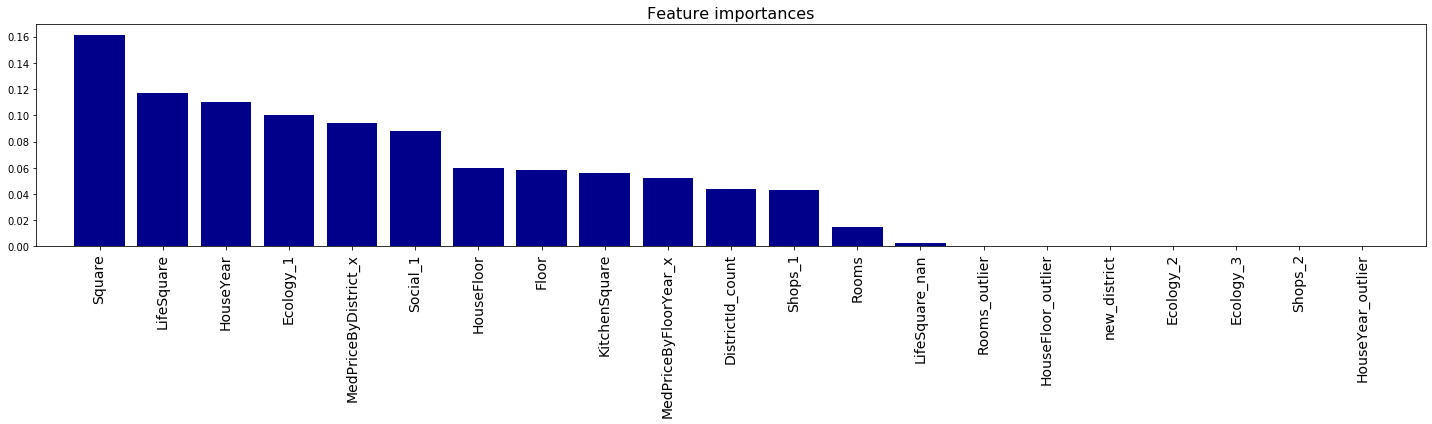

In [34]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [35]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('realestatepriceprediction/predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,148037.494990
1,15856,243739.747640
2,5480,179816.957007
3,15664,342721.944396
4,14275,142272.457822


In [36]:
preds_final.shape

(5000, 2)

In [4]:
# X.info()

In [5]:
# X_final.info()

In [6]:
# class FeatureGenetator():
#     """Генерация новых фич"""
    
#     def __init__(self):
#         self.DistrictId_counts = None
#         self.binary_to_numbers = None
#         self.med_price_by_district = None
#         self.med_price_by_floor_year = None
        
#     def fit(self, X, y=None):
        
#         X = X.copy()
        
#         # DistrictID
#         district = X['DistrictId'].value_counts()
#         district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
#                                            ## Хотя на локальной валидации скор вырастет
        
#         self.DistrictId_counts = dict(district)
        
#         # Binary features
#         self.binary_to_numbers = {'A': 0, 'B': 1}
        
#         # Target encoding
#         ## District
#         df = X.copy()
        
#         if y is not None:
#             df['Price'] = y.values
#                        df['DistrictId_popular'] = df['DistrictId'].copy()
#             df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
#             self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
#                                             rename(columns={'Price':'MedPriceByDistrict',
#                                                            'DistrictId_popular': 'DistrictId'})
            
#         ## floor, year
#         if y is not None:
#             df['Price'] = y.values
#             df = self.floor_to_cat(df)
#             df = self.year_to_cat(df)
#             self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
#                                                         rename(columns={'Price':'MedPriceByFloorYear'})
        

        
#     def transform(self, X):
        
#         # DistrictId
#         X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
#         X['new_district'] = 0
#         X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
#         X['DistrictId_count'].fillna(5, inplace=True)
        
#         # Binary features
#         X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
#         X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
#         X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
#         # More categorical features
#         X = self.floor_to_cat(X)  # + столбец floor_cat
#         X = self.year_to_cat(X)   # + столбец year_cat
        
#         # Target encoding
#         if self.med_price_by_district is not None:
#             X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
#         if self.med_price_by_floor_year is not None:
#             X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
#         return X
    
#     @staticmethod
#     def floor_to_cat(X):
#         X['floor_cat'] = np.nan
        
#         X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
#         X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
#         X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
#         X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
#         X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
#         return X
#     @staticmethod
#     def year_to_cat(X):
        
#         X['year_cat'] = np.nan
        
#         X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
#         X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
#         X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
#         X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
#         X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
#         X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
#         return X
            